# Q(σ) method

Imlementation of the Q(σ) method introduced [**here**](http://demiledge.com/artificialIntelligence/nstepsTD.php##n-stepstdq(σ)

In [55]:
import gym
env=gym.make("Taxi-v2")#import the game

print("Number of actions:",env.action_space.n)
print("Number of states:",env.observation_space.n)

Number of actions: 6
Number of states: 500


# Agent

In [56]:
import numpy as np
import random

episodes=1000

def agent(epsilon,nsteps,alpha, decay, sg):
    QTable=np.zeros([env.observation_space.n,env.action_space.n])

    epsilon=epsilon
    nsteps=nsteps
    alpha=alpha
    discount=0.99
    epsilon_decay=0.99
    sigma=sg
    stepsEpisode=[]
    rewardsEpisode=[]

    def policy(state):
        if random.random()<epsilon:
            return env.action_space.sample()
        else:
            bestActions=np.argwhere(state==np.amax(state))
            return int(np.random.choice(np.reshape(bestActions, -1)))

    def computeExpectation(actions):
        #retrieve the actions with highest value and pick just 1 randomly
        bestAction=np.random.choice(np.reshape(np.argwhere(actions==np.amax(actions)), -1))
        probs=[]
        for idx,act in enumerate(actions):
            if idx==bestAction:
                prob=(1-epsilon) + (epsilon/env.action_space.n)
                probs.append(prob)
            else:
                probs.append(epsilon/env.action_space.n)
        return probs
            
        
    for episode in range(episodes):
        valueFunctions=[]
        rewards=[]
        
        #set dynamic sigma change from 1 to 0 after some number of episodes
        if sg!="alternate" and sg>1:
            if episode<=sg:
                sigma=1
            else:
                sigma=0

        d=False
        totRewards=0
        step=0

        s=env.reset()

        action=policy(QTable[s])

        while not(d):
            #env.render()
            s1,r,d,_=env.step(action)
            
            valueFunctions.append([s,action])
            rewards.append(r)

            nextAction=policy(QTable[s1])

            if step>=nsteps:
                G=0
                #start from the last state stored and iterate backward 1 by 1 until the state 0 excluded
                #which is the state that is going to be update
                for t in range(nsteps, 0 ,-1):
                    #retrieve the idx of the action executed at the state s'
                    actionExecuted=valueFunctions[t][1]
                    #retrieve the s'
                    state=valueFunctions[t][0]
                    
                    #is sigma alternated, at every n change between 0 and 1 sigma
                    if sg=="alternate":
                        if t%2!=0:
                            sigma=1
                        else:
                            sigma=0
                    
                    #if sigma=1
                    if sigma==1:
                        #sample update
                        if t==nsteps:
                            G=rewards[t-1] + discount*QTable[state][actionExecuted]
                        else:
                            G=rewards[t-1] + discount * G
                    else:
                        #expected update
                        if t==nsteps:
                            #if it is the last state, compute expectation across all actions                            
                            actionProbs=computeExpectation(QTable[state])
                            expectation=np.sum(actionProbs*QTable[state])
                            
                            #compute last lambda (lambda t+2 if you look the article)
                            G=rewards[t-1] + discount * expectation
                        else:
                            #if not last state, compute expectation excluded the action selected 
                            actionProbs=computeExpectation(QTable[state])
                            expectation=0
                            
                            for idx,prob in enumerate(actionProbs):
                                if idx==actionExecuted:
                                    expectation+= prob * G
                                else:
                                    expectation += prob * QTable[state][idx]
                            #compute lambda t+1
                            G=rewards[t-1] + discount * expectation

                #update q(s,a) (state 0)
                qs=valueFunctions[0][0]
                qa=valueFunctions[0][1]
                QTable[qs][qa]=QTable[qs][qa] + alpha * (G - QTable[qs][qa])
                

                del valueFunctions[0]
                del rewards[0]

            #if the game is finished, finish to update the states
            if d:
                while len(valueFunctions)>0:
                    G=0
                    elementsLeft=len(valueFunctions)-1
                    for t in range(elementsLeft,0,-1):
                        actionExecuted=valueFunctions[t][1]
                        state=valueFunctions[t][0]
                        
                        if sg=="alternate":
                            if t%2!=0:
                                sigma=1
                            else:
                                sigma=0
                                
                        if sigma==1:
                            #sample update
                            G=rewards[t-1] + discount * G
                        else:
                            actionProbs=computeExpectation(QTable[state])
                            expectation=0
                            for idx,prob in enumerate(actionProbs):
                                if idx==actionExecuted:
                                    expectation+= prob * G
                                else:
                                    expectation += prob * QTable[state][idx]
                            #compute lambda 
                            G=rewards[t-1] + discount * expectation

                    #update q(s,a)
                    qs=valueFunctions[0][0]
                    qa=valueFunctions[0][1]
                    QTable[qs][qa]=QTable[qs][qa] + alpha * (G - QTable[qs][qa])

                    del valueFunctions[0]
                    del rewards[0]


            action=nextAction
            s=s1

            step+=1
            totRewards+=r

        stepsEpisode.append(step)
        rewardsEpisode.append(totRewards)
        
        if decay:
            epsilon=epsilon*epsilon_decay
        
    #training finished, return results
    return stepsEpisode, rewardsEpisode

## Training

In [57]:
nstepsList=[1,3,7]
alphaList=[0.4,0.9]
sigma=[1,0,150,"alternate"]

#store the top 2 best settings for each nstep algorithm
bestAgentSettings=[]
agentStepsResults=[]
agentRewardsResults=[]

for nsteps in nstepsList:
    print("\n**** STARTING SET ****\n")
    nstepBestReward=[]
    nstepBestSettings=[]
    nstepStepsResults=[]
    nstepRewardsResults=[]
    for alpha in alphaList:
        for sg in sigma:
            #run the agent
            st, rw=agent(0.2,nsteps,alpha, True, sg)
            
            print("Training agent with nsteps={}, e={}, alpha={}, sigma={}".format(nsteps,0.2,alpha, sg))
            if len(nstepBestReward)>=2:
                minValue=np.amin(nstepBestReward)
                if np.sum(rw)>minValue:
                    position=int(np.argwhere(nstepBestReward==minValue))
                    #remove the old agent, add the new one
                    nstepBestReward[position]=np.sum(rw)
                    nstepBestSettings[position]=[0.2,nsteps,alpha,sg,str(True)]
                    nstepStepsResults[position]=st
                    nstepRewardsResults[position]=rw
            else:
                nstepBestReward.append(np.sum(rw))
                nstepBestSettings.append([0.2,nsteps,alpha,sg,str(True)])
                nstepStepsResults.append(st)
                nstepRewardsResults.append(rw)
            status=not(status)
                
    #store the 2 best for every nstep algorithm
    for idx,_ in enumerate(nstepBestSettings):
        bestAgentSettings.append(nstepBestSettings[idx])
        agentStepsResults.append(nstepStepsResults[idx])
        agentRewardsResults.append(nstepRewardsResults[idx])


**** STARTING SET ****

Training agent with nsteps=1, e=0.2, alpha=0.4, sigma=1
Training agent with nsteps=1, e=0.2, alpha=0.4, sigma=0
Training agent with nsteps=1, e=0.2, alpha=0.4, sigma=150
Training agent with nsteps=1, e=0.2, alpha=0.4, sigma=alternate
Training agent with nsteps=1, e=0.2, alpha=0.9, sigma=1
Training agent with nsteps=1, e=0.2, alpha=0.9, sigma=0
Training agent with nsteps=1, e=0.2, alpha=0.9, sigma=150
Training agent with nsteps=1, e=0.2, alpha=0.9, sigma=alternate

**** STARTING SET ****

Training agent with nsteps=3, e=0.2, alpha=0.4, sigma=1
Training agent with nsteps=3, e=0.2, alpha=0.4, sigma=0
Training agent with nsteps=3, e=0.2, alpha=0.4, sigma=150
Training agent with nsteps=3, e=0.2, alpha=0.4, sigma=alternate
Training agent with nsteps=3, e=0.2, alpha=0.9, sigma=1
Training agent with nsteps=3, e=0.2, alpha=0.9, sigma=0
Training agent with nsteps=3, e=0.2, alpha=0.9, sigma=150
Training agent with nsteps=3, e=0.2, alpha=0.9, sigma=alternate

**** STARTING

In [58]:
#CALCULATE MOVING AVERAGE OF WINDOW=5
def movingAverage(data, size=50):
    averagedData=[]
    for idx, item in enumerate(data,1):
        if idx>=size:
            movAvg=np.sum(data[idx-size:idx])/size
        else:
            movAvg=np.sum(data[:idx])/idx
        averagedData.append(movAvg)
        
    return averagedData

newAgentStepsResults=[]
newAgentRewardsResults=[]
for idx, element in enumerate(agentStepsResults):
    newAgentStepsResults.append(movingAverage(agentStepsResults[idx]))
    newAgentRewardsResults.append(movingAverage(agentRewardsResults[idx]))

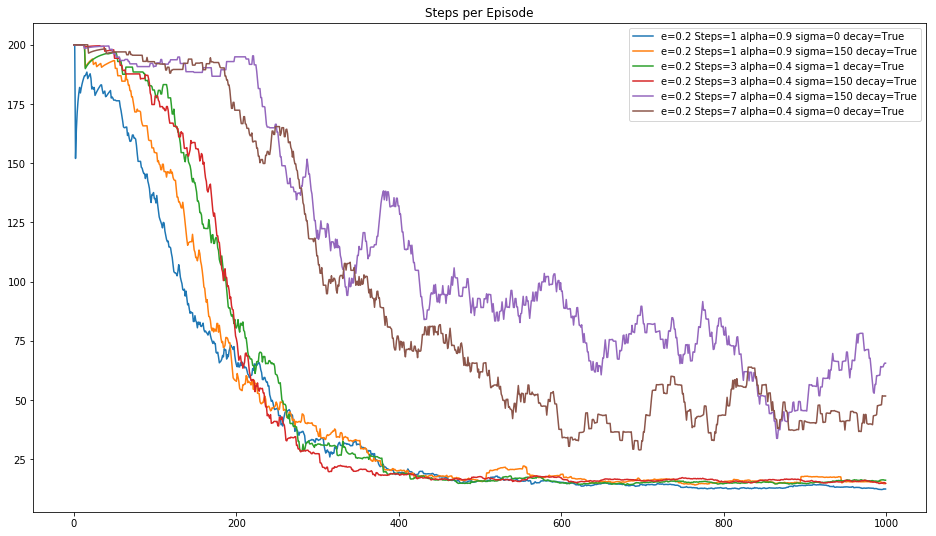

In [59]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [16,9]
#f=plt.figure()
x=[i for i in range(episodes)]

#plt1=f.add_subplot(2,1,1)
for idx,agent in enumerate(bestAgentSettings):
    string="e="+str(agent[0])+" Steps="+str(agent[1])+" alpha="+str(agent[2])+" sigma="+str(agent[3])+" decay="+str(agent[4])
    plt.plot(x, newAgentStepsResults[idx], label=string)
plt.title("Steps per Episode")
plt.legend(loc=0)

plt.show()

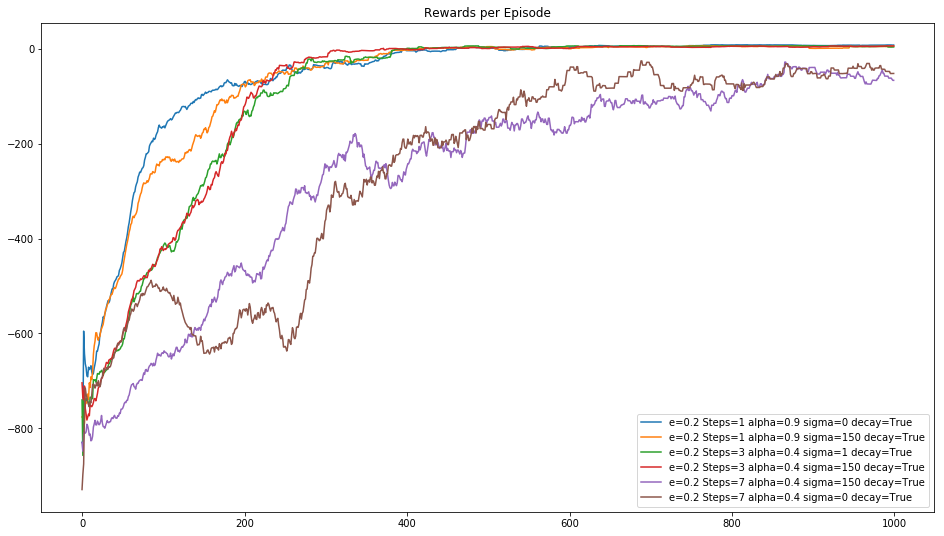

In [60]:
for idx,agent in enumerate(bestAgentSettings):
    string="e="+str(agent[0])+" Steps="+str(agent[1])+" alpha="+str(agent[2])+" sigma="+str(agent[3])+" decay="+str(agent[4])
    plt.plot(x, newAgentRewardsResults[idx], label=string)
            
plt.title("Rewards per Episode")
plt.legend(loc=0)

plt.show()

The blue line (*Expected SARSA*), as well as the yellow line (first 150 episodes *SARSA* then *Expected SARSA*) outperform the others at the beginning. However, around episode 200, *3-step Q(σ)* starts to obtain the best rewards. 

In this case, there isn't substantial difference between *sample update* and *expected update* as well as different models with different *n-step* and *Q(σ) method*. 

The only remarkable result is that *7-step perform very poorly throughout the entire training.